# Loan prediction : Classification

#### Repository: link to my OneDrive
###### where you'll find the original notebook

https://liveuclac-my.sharepoint.com/:u:/g/personal/uceis36_ucl_ac_uk/EVIetWv5sShDuuWC9igosSkBD7t_c5MzuDh4_RhAgYSNcw?e=kW000W

## All imports

In [15]:
# loading essential libraries
import pandas as pd
import os
import numpy as np
import datetime
 
#import all needed libraries from sklearn
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, roc_curve
from sklearn.svm import LinearSVC

In [16]:
#For plotting
import seaborn as sns  #to make plots using seaborn
color = sns.color_palette()
import matplotlib
import matplotlib.pyplot as plt  #for plotting

In [17]:
#import classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#to make sure everythings is stable when running
np.random.seed(42)

In [18]:
import warnings
warnings.filterwarnings("ignore")

# Problem framing


Thera Bank, a new bank, is aiming to grow its customer base and more importantly to increase its number of borrowers, since loans and other  lending products are banks' main profit sources, through the generation of net interest income. 

However, not all customers within a bank have equal likelihood of taking loans: indeed, depending on their level of education, professional experience, age or any other demographic, they have more or less chances to borrow money from the banks. Hence the latter entity should put efforts into targeting the right segmenting. 

An accurate strategy to achieve this objective would be through customer classification. Using a classification model to predict the likelihood of a liability customer (depositor) buying personal loans is an efficient strategy to make sure we are targeting the right group of customers. Retaining the newly acquired borrowers as depositors will generate profit and expand Thera Bank's business. 

## Data cleaning

#### link to the dataset
 https://www.kaggle.com/itsmesunil/bank-loan-modelling?select=Bank_Personal_Loan_Modelling.xlsx

In [19]:
#loading the dataset
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx',
                   sheet_name='Data')
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [20]:
"This dataset has {0} rows and {1} columns".format(len(df),
                                                   len(df.columns))

'This dataset has 5000 rows and 14 columns'

For more clarity, here is a breakdown of the meaning of each variable found in the dataset (according to the dataset's creator:
- 'ID' = Customer ID							
- 'Age'	= Customer's age							
- 'Experience'=	number of years of professional experience							
- 'Income' = Annual income of the customer ( USD 000)							
- 'ZIPCode'	= Home Address ZIP code.							
- 'Family'	= Family size of the customer							
- 'CCAvg' = average spending on credit cards per month (USD 000)							
- 'Education' = Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional							
- 'Mortgage' = Value of house mortgage if any. ( USD 000 )							
- 'Personal Loan' = Did this customer accept the personal loan offered in the last campaign?
- 'Securities Account'	Does the customer have a securities account with the bank?							
- 'CD Account'	Does the customer have a certificate of deposit (CD) account with the bank?							
- 'Online' = Does the customer use internet banking facilities?							
- 'CreditCard' = Does the customer use a credit card issued by UniversalBank?

In [21]:
df.info()
"There are {0} number of rows with at least 1 missing value".format(df.shape[0] - df.dropna().shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


'There are 0 number of rows with at least 1 missing value'

In [22]:
#There seems to be no missing values, but let's confirm it
df.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

**There seems to be no missing values at all.**

## Exploratory Data Analysis

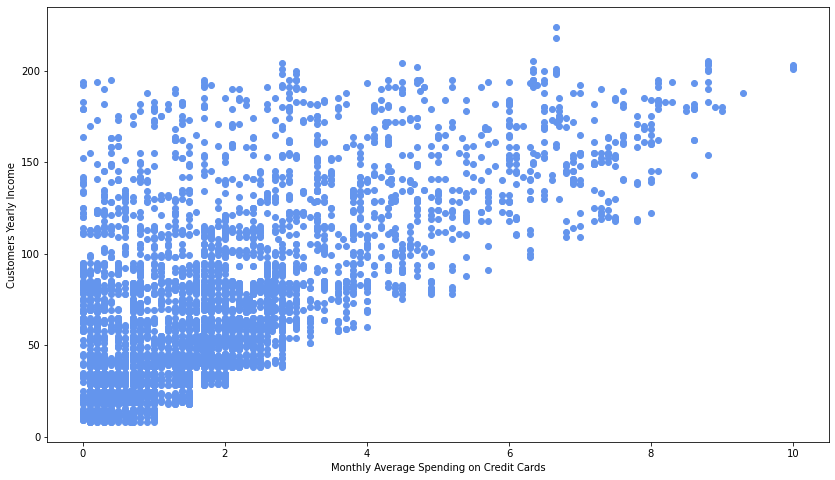

In [23]:
#let's further analyse the distribution with a 
#scatterplot and try to analyse a potential relationship between
#customers' income and credit card spendings

fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(df['CCAvg'], df['Income'], 
           color = "cornflowerblue")  #to create the scatter plot
ax.set_xlabel('Monthly Average Spending on Credit Cards')
ax.set_ylabel('Customers Yearly Income')
plt.show()

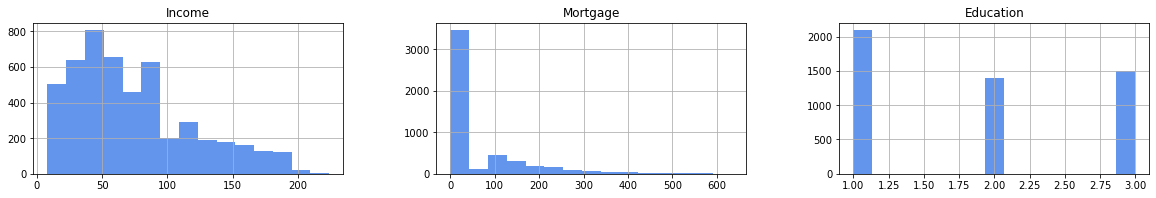

In [24]:
num_feat = ["Income", "Mortgage", "Education"] 
categorical_feat = ["Securities Account", "CD Account", "Online",
                    "CreditCard", "Family", "CCAvg"]

df[num_feat].hist(bins=15, figsize=(20, 10), layout=(3, 3), 
                  color ="cornflowerblue");

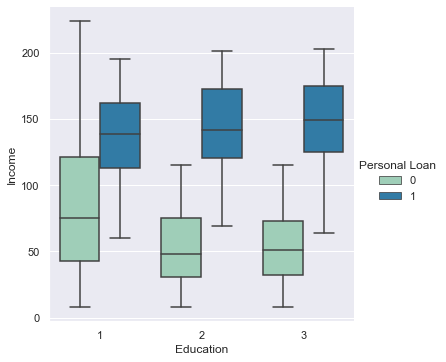

In [124]:
#plotting the relationship of Education and Income 
#against Personal Loan
sns.catplot(x='Education', y = 'Income', data = df,kind= 'box',
            hue='Personal Loan', palette =  "YlGnBu")

We notice the more income a person earns (usually between USD 110,000 and USD 175,000 per year), the most likely they are to make a loan, which is most likely due to their financial stability and banks being more confident in their reimbursing capabilites, so lending them more money.
This trend slightly confirms itself with a higher education level, but the change is marginal. 

<AxesSubplot:xlabel='CCAvg', ylabel='Income'>

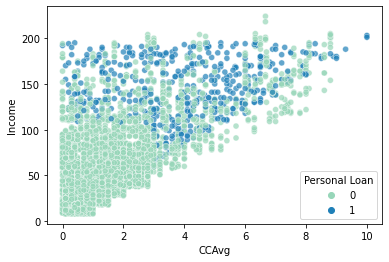

In [26]:
#plotting the relationship of CCAvg and Income 
#against Personal Loan
sns.scatterplot(x='CCAvg', y = 'Income', data = df, hue='Personal Loan', 
                alpha = 0.7, palette = "YlGnBu")

It seems that there is a high correlation between having a high income (more than USD 100,000 per year), spending high amounts of money per month (more than USD 2,000) and the likelihood of getting a personal loan. Whereas on the other hand, low income earners spend less and also have less chance of making a loan, probably for the same reason as stated above. 

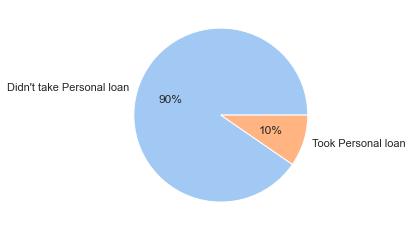

In [134]:
#pie chart with target feature's (personal loan) distribution
data = df['Personal Loan'].value_counts().values.tolist()
labels = ["Didn't take Personal loan", 'Took Personal loan']
colors = sns.color_palette('pastel')[0:2]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

* This dataset is **imbalanced** as only 10% of the scope of customers have taken a personal loan from the bank.

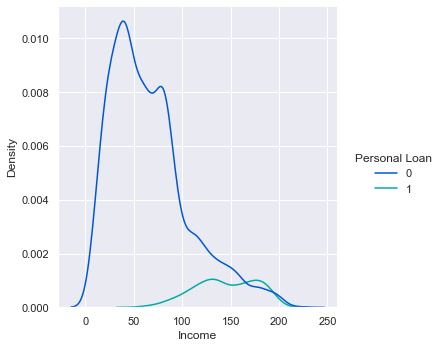

In [135]:
#chart that shows distribution of categorical var
sns.displot(data=df, x="Income", hue="Personal Loan", 
            kind="kde", palette = 'winter')

* This graph shows us that people with **higher income are more willing to take a personal loan** from the bank than the people with lower income. Moreover, in the income range of 175 and 200, there are more people willing to take a personal loan than people not willing to take it and knowing that only 10% of the customers have taken a personal loan, it shows **how important the feature Income really is**.

<AxesSubplot:xlabel='Education', ylabel='Count'>

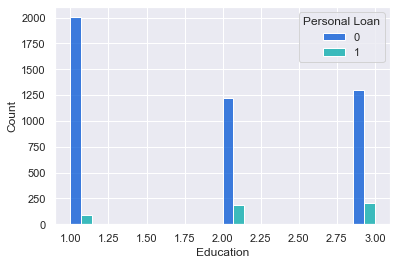

In [136]:
#bar chart with different levels of education 
#against personal loan
sns.histplot(x="Education", hue="Personal Loan", data=df, 
             palette = 'winter', multiple = 'dodge')

* In this graph, we see the chances of someone taking a personal loan growing with the degree of education.

In [30]:
df.describe() 
#to see some interesting distribution, especially in CCAvg 
#to then potentially create bins for some of the features if needed

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


There seems to be some (sometimes important) discrepancy between the mean and 50% for the following variables:
- Mortgage
- Income
- Education
- CCAvg
That means there are probably outliers, which we are going to examine in the following steps. 

<AxesSubplot:xlabel='Income'>

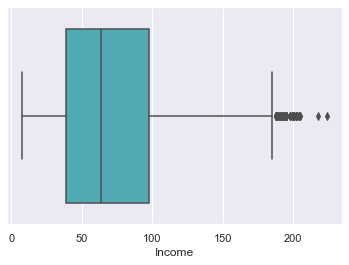

In [125]:
#let's see if there are outliers for Income
sns.set(style="darkgrid")
sns.boxplot(x=df['Income'], palette = "YlGnBu")



* Here there seems to be some outliers for the feature 'Income', especially after USD 180,000 per year. We can assume most customers earn between USD 40,000 and USD 180,000 a year.

<AxesSubplot:xlabel='CCAvg'>

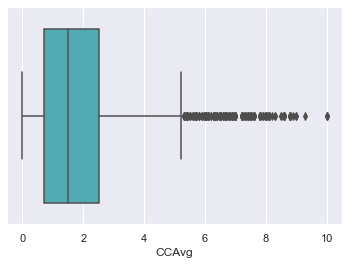

In [126]:
#let's see if there are outliers for CCAvg
sns.set(style="darkgrid")
sns.boxplot(x=df['CCAvg'], palette = "YlGnBu")

* As we can see from the boxplot above, there seems to be a lot of outliers from USD 5,500 to USD 10,000 of spending a month: this means most of Thera Bank's clients spend less.

<AxesSubplot:xlabel='Mortgage'>

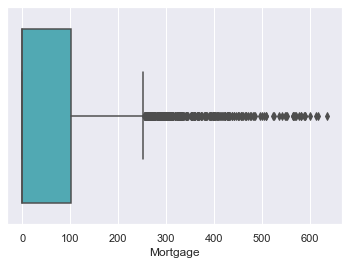

In [128]:
#let's see if there are outliers for Mortgage
sns.set(style="darkgrid")
sns.boxplot(x=df['Mortgage'], palette = "YlGnBu")

<AxesSubplot:xlabel='Income'>

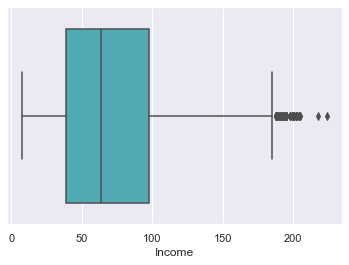

In [130]:
#let's see if there are outliers for Income
sns.set(style="darkgrid")
sns.boxplot(x=df['Income'], palette = "YlGnBu")

In [36]:
#we're further examining how the values in CCAvg are distributed 
for c in df.columns[:]:
    unique_vals = df[c].unique()   #to see the unique values in CCAvg
    print(c,"---",df[c].dtypes,"\n",unique_vals,"\n")  
    
df["CCAvg"].max()
df["CCAvg"].min()
df["CCAvg"].median()  
    

ID --- int64 
 [   1    2    3 ... 4998 4999 5000] 

Age --- int64 
 [25 45 39 35 37 53 50 34 65 29 48 59 67 60 38 42 46 55 56 57 44 36 43 40
 30 31 51 32 61 41 28 49 47 62 58 54 33 27 66 24 52 26 64 63 23] 

Experience --- int64 
 [ 1 19 15  9  8 13 27 24 10 39  5 23 32 41 30 14 18 21 28 31 11 16 20 35
  6 25  7 12 26 37 17  2 36 29  3 22 -1 34  0 38 40 33  4 -2 42 -3 43] 

Income --- int64 
 [ 49  34  11 100  45  29  72  22  81 180 105 114  40 112 130 193  21  25
  63  62  43 152  83 158  48 119  35  41  18  50 121  71 141  80  84  60
 132 104  52 194   8 131 190  44 139  93 188  39 125  32  20 115  69  85
 135  12 133  19  82 109  42  78  51 113 118  64 161  94  15  74  30  38
   9  92  61  73  70 149  98 128  31  58  54 124 163  24  79 134  23  13
 138 171 168  65  10 148 159 169 144 165  59  68  91 172  55 155  53  89
  28  75 170 120  99 111  33 129 122 150 195 110 101 191 140 153 173 174
  90 179 145 200 183 182  88 160 205 164  14 175 103 108 185 204 154 102
 192 202 162 142  9

1.5

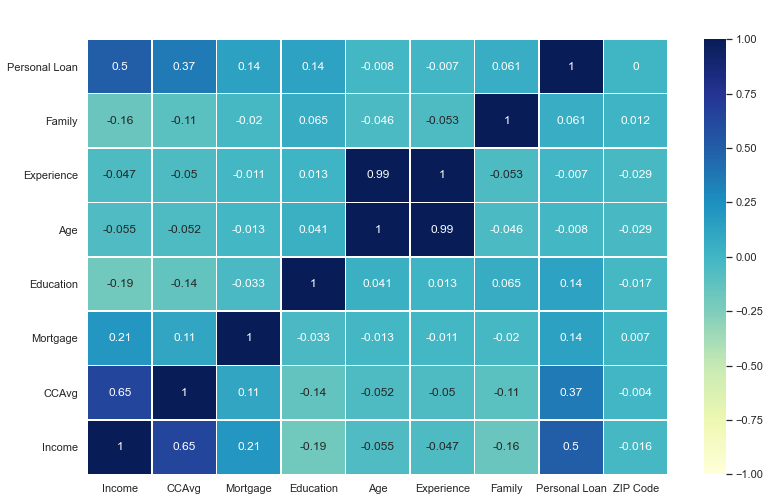

In [37]:
#let's analyse the different relationships between the variables through a correlation matrix
CorrVar = ["Income", "CCAvg", "Mortgage", "Education", "Age", 
           "Experience", "Family", "Personal Loan", "ZIP Code"]

corrMatrix = df[CorrVar].corr().apply(lambda x:round(x,3))
plt.figure(figsize = (13,8))   #plotting correlation matrix
ax = sns.heatmap(corrMatrix, annot = True , vmin = -1, vmax = 1, 
                 center = 0, cmap="YlGnBu", linewidths=.5)   #choosing details
ax.set_ylim([0,8])
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation = 0,
    horizontalalignment = 'right'    
)
plt.show();

* Intuitively, the correlation matrix above depicts a strong correlation between some features such as 'Income' and 'CCAvg'. The correlation between 'Experience' and 'Age' is also extremely high (0.99), but their respective correlation with our target feature 'Personal Loan' is close to zero: this tells us these variables are not going to bring any value to our modelling section later on (multicollinearity), so it is preferable to drop them afterwards in the data preprocessing.   
Similarly, the variable ZIP Code doesn't seem to be useful as well (correlation with Personal Loan is zero). 

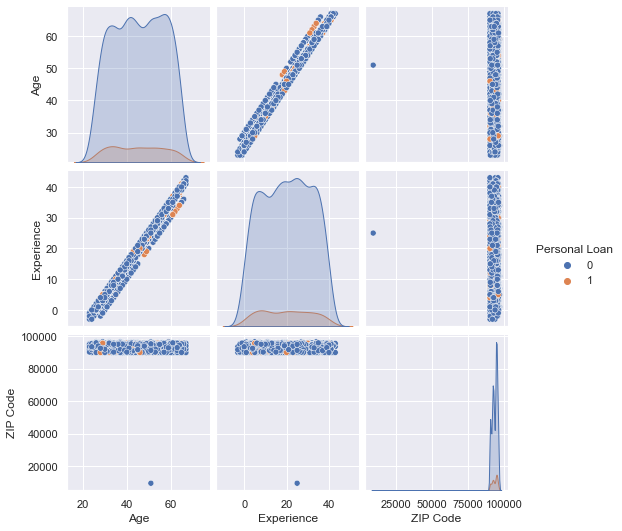

In [38]:
#let's confirm the correlations between Age, Experience, 
#Personal Loan, ZIP Code. 
sns.pairplot(df[['Age', 'Experience', 'Personal Loan', 'ZIP Code']], 
             hue = 'Personal Loan')

 
Two things can be understood from these plots : 

* First, Age and Experience are highly correlated (see correlation matrix above - correlation of 99%) and the scatterplot of these two features is a line. 
* Second, for the features Age, Experience and ZIP Code, there seem to be no difference between the distribution of people who took personal loan and people who didn't. This shows how uncorrelated these features are to the target "Personal Loan" and these features shoudld therefore be dropped.

## Feature Engineering

Given the distribution of the credit card monthly spending ('CCAvg'), it is safe to classify its data into 4 categories (bins) that we'll then compare analyse in the feature engineering. 

#### Binning CCAvg by quartiles and Education by categories

In [39]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [66]:
#creating four bins for the 4 tiers of spenders in CCAvg
def divide_into_quartiles(x):
    if x < 0.7:
        return 0
    elif x >= 0.7 and x < 1.5:
        return 1
    elif x >= 1.5 and x < 2.5:
        return 2
    else: 
        return 3

In [67]:
#applying our new CCAvg bins to a modified dataset called df_engineered
df_engineered = df.copy()
df_engineered['CCAvg'] = df_engineered['CCAvg'].apply(divide_into_quartiles)

In [49]:
df.head()
#based on this and the unique values in Education, 
#we also know the three different education levels

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [51]:
def divide_into_categories(x):
    if x == 1:
        return 'Undergraduate'
    elif x == 2:
        return 'Graduate'
    else: 
        return 'Advanced/Professional'

In [52]:
#applying our new Education bins to a modified dataset called df_engineered
df_engineered = df.copy()
df_engineered['Education'] = df_engineered['Education'].apply(divide_into_categories)

In [68]:
df_engineered

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,2,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,2,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,3,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,2,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0,2,0,0,0,0,1,0


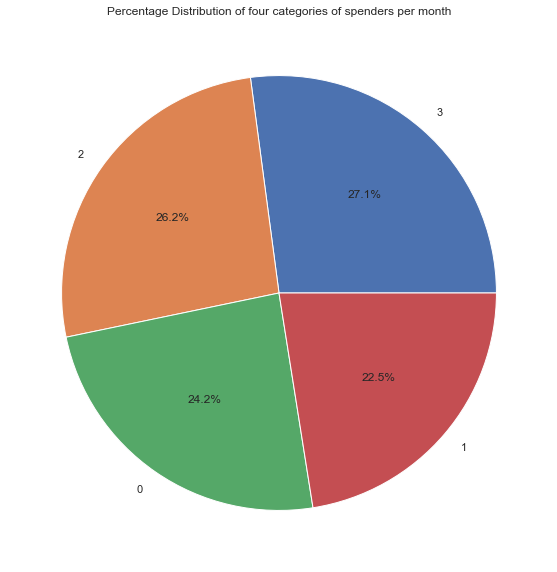

In [133]:
#let's look at how much clients at Thera Bank spend per month


pie =df_engineered.groupby(by=["CCAvg"]).size().reset_index(name="counts")
pie= pie.nlargest(11,['counts'])
plt.figure(figsize=(10,10))
plt.pie(x=pie['counts'],labels=pie['CCAvg'],autopct='%1.1f%%')
plt.title('Percentage Distribution of four categories of spenders per month')
plt.show()

From the graph above, it seems that Thera Bank's customers are equally distributed in terms of spending levels. 

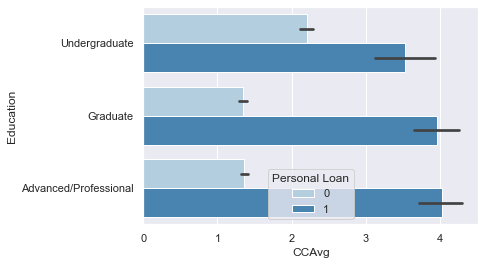

In [62]:
ax = sns.barplot(x="CCAvg", y="Education", hue="Personal Loan", 
                 data=df_engineered, palette = "Blues")

It seems that the more someone is educated and spends money, the more chance they have of taking a Personal Loan, and vice-versa. 

### Taking out non relevant features - Age/Experience

In [72]:
df_engineered = df_engineered.drop(['Age', 'Experience', 'ID', 'ZIP Code'], axis = 1)

## Modelling

### Simple train_test_split

In [73]:
X= df.drop('Personal Loan',axis = 1)
y= df['Personal Loan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 5)

In [74]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("KNeighbors' prediction accuracy is {} and AUC score is {}.".format(acc, auc))

KNeighbors' prediction accuracy is 0.913 and AUC score is 0.6187512460127591.


In [75]:
clf = XGBClassifier()
clf.fit(X_train, y_train, eval_metric=["auc"])
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("XGBoost's prediction accuracy is {} and AUC score is {}.".
      format(acc, auc))

XGBoost's prediction accuracy is 0.986 and AUC score is 0.996012759170654.


In [76]:
df["Personal Loan"].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

After value counting the target feature Personal Loan, we can see the dataset is heavily imbalanced. Hence the  accuracy score is not the most appropriate score to use in order to determine the best classifier, that's why we also used the AUC Score.

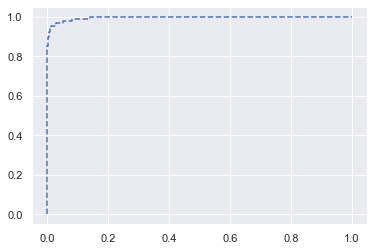

In [77]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC')

<AxesSubplot:>

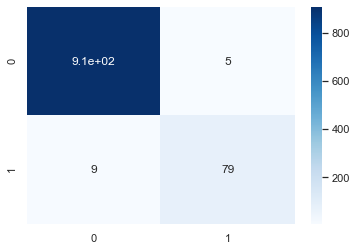

In [78]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [79]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("RandomForest's prediction accuracy is {} and AUC score is {}.".
      format(acc, auc))

RandomForest's prediction accuracy is 0.992 and AUC score is 0.9957822468102073.


<AxesSubplot:>

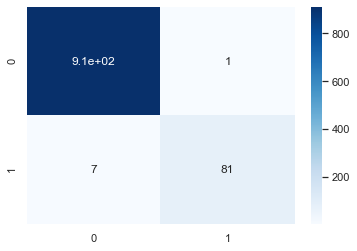

In [80]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [81]:
clf = ExtraTreesClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("ExtraTrees's prediction accuracy is {} and AUC score is {}.".
      format(acc, auc))

ExtraTrees's prediction accuracy is 0.98 and AUC score is 0.9880008971291867.


<AxesSubplot:>

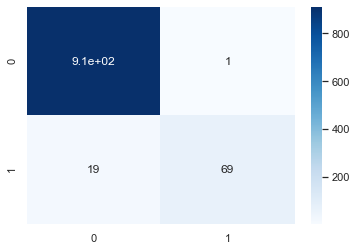

In [82]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [83]:
clf = BaggingClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Bagging's prediction accuracy is {} and AUC score is {}.".
      format(acc, auc))

Bagging's prediction accuracy is 0.985 and AUC score is 0.9861505681818182.


<AxesSubplot:>

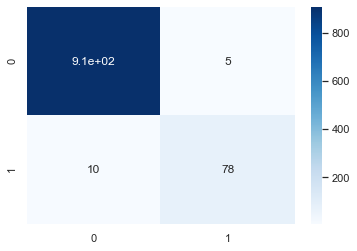

In [84]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [85]:
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("AdaBoost's prediction accuracy is {} and AUC score is {}.".
      format(acc, auc))

AdaBoost's prediction accuracy is 0.973 and AUC score is 0.9812475079744817.


<AxesSubplot:>

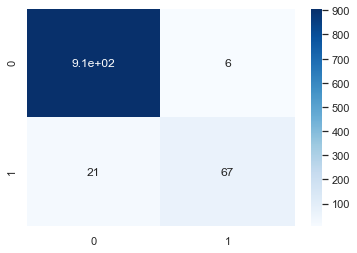

In [86]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [87]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("GradientBoosting's prediction accuracy is {} and AUC score is {}.".
      format(acc, auc))

GradientBoosting's prediction accuracy is 0.985 and AUC score is 0.9975079744816587.


<AxesSubplot:>

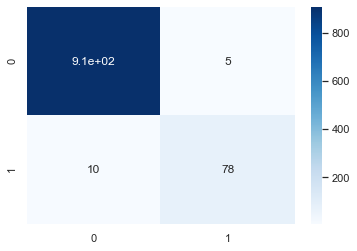

In [88]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [89]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("LogisticRegression's prediction accuracy is {} and AUC score is {}.".
      format(acc, auc))

LogisticRegression's prediction accuracy is 0.919 and AUC score is 0.9275194377990431.


<AxesSubplot:>

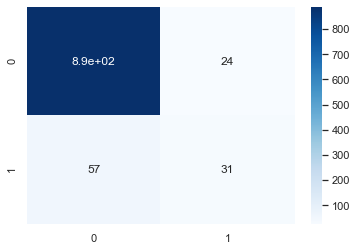

In [90]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

### Cross validation

In [91]:
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier(eval_metric=["auc"])
rf_clf = RandomForestClassifier()
et_clf = ExtraTreesClassifier()
bag_clf = BaggingClassifier()
ada_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
lr_clf = LogisticRegression()
scores_knn = cross_val_score(knn_clf, X, y, cv = 5)
scores_xgb = cross_val_score(xgb_clf, X, y, cv = 5)
scores_rf = cross_val_score(rf_clf, X, y, cv = 5)
scores_et = cross_val_score(et_clf, X, y, cv = 5)
scores_bag = cross_val_score(bag_clf, X, y, cv = 5)
scores_ada = cross_val_score(ada_clf, X, y, cv = 5)
scores_gb = cross_val_score(gb_clf, X, y, cv = 5)
scores_lr = cross_val_score(lr_clf, X, y, cv = 5)
results = f"""
KNeighbors' prediction accuracy is {scores_knn.mean()}
XGBoost's prediction accuracy is {scores_xgb.mean()}
RandomForest's prediction accuracy is {scores_rf.mean()}
ExtraTrees's prediction accuracy is {scores_et.mean()}
Bagging's prediction accuracy is {scores_bag.mean()}
AdaBoost's prediction accuracy is {scores_ada.mean()}
GradientBoosting's prediction accuracy is {scores_gb.mean()}
LogisticRegression's prediction accuracy is {scores_lr.mean()}
"""
print(results)



KNeighbors' prediction accuracy is 0.8584000000000002
XGBoost's prediction accuracy is 0.984
RandomForest's prediction accuracy is 0.9847999999999999
ExtraTrees's prediction accuracy is 0.9798
Bagging's prediction accuracy is 0.9814
AdaBoost's prediction accuracy is 0.9558
GradientBoosting's prediction accuracy is 0.9843999999999999
LogisticRegression's prediction accuracy is 0.9156000000000001



After comparing all the classifiers chosen to run the classification task above, it appears the best model so far –with no preprocessing on the dataset yet– is Random Forest with an accuracy score of 98.47% and the weakest model is KNeighbors with a predicted accuracy score of 85.84% and it also presents the highest number of false positives and false negatives in the confusion matrix. Furthermore, Random Forest has the highest number of true positives and the least false negatives. 

## Data preprocessing

### Scaling numerical features

In this section, we are going to run the same classifiers a second time with a fine-tuned dataset (see: df.engineered), to see if we can get our accuracy scores to improve even more. 

In [92]:
num_feat = ["Income", "Mortgage", "Education"] 

#these categorical variables are already binary
categorical_feat = ["Securities Account", "CD Account", 
                    "Online", "CreditCard"]    

#preparing some features to one hot encode
categorical_feat_to_onehot_encode = ["Family", "CCAvg"]    


In [93]:
#let's scale the numerical features to avoid confusing the 
#classifiers with drasitically different numerical values
scaler = StandardScaler()
df_engineered[num_feat] = scaler.fit_transform(df_engineered[num_feat])

In [94]:
df_engineered

,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,-0.538229,4,2,-1.049078,-0.555524,0,1,0,0,0
1,-0.864109,3,2,-1.049078,-0.555524,0,1,0,0,0
2,-1.363793,1,1,-1.049078,-0.555524,0,0,0,0,0
3,0.569765,1,3,0.141703,-0.555524,0,0,0,0,0
4,-0.625130,4,1,0.141703,-0.555524,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
4995,-0.733757,1,2,1.332484,-0.555524,0,0,0,1,0
4996,-1.276892,4,0,-1.049078,0.280238,0,0,0,1,0
4997,-1.081363,2,0,1.332484,-0.555524,0,0,0,0,0
4998,-0.538229,3,0,0.141703,-0.555524,0,0,0,1,0


### One-hot encoding categorical features

In [95]:
#here we're one hot encoding some of the categorical values
enc = OneHotEncoder()
cols_dict = {i: 'Family_' + str(i) for i in range(4)}
cols_family = ['Family_' + str(i) for i in range(4)]
df_engineered[cols_family] = pd.DataFrame(enc.
                                          fit_transform(df_engineered[['Family']]).
                                          toarray()).rename(columns = cols_dict)

In [96]:
enc = OneHotEncoder()
cols_dict = {i: 'CC_Avg_' + i for i in ['Low', 'Average', 'High', 'Very_High']}
cols_ccavg = ['CC_Avg_' + i for i in ['Low', 'Average', 'High', 'Very_High']] 
df_engineered[cols_ccavg] = pd.DataFrame(enc.fit_transform(df_engineered[['CCAvg']]).
                                         toarray()).rename(columns = cols_dict)

In [97]:
#now we're putting all our features in X except for the target feature, 
#Personal Loan, that we're putting in y
X = df_engineered[num_feat + categorical_feat + cols_family + cols_ccavg]
y = df_engineered['Personal Loan']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 5)

**APPLYING THE SAME CLASSIFIERS TO THIS NOW TRANSFORMED DATASET - to see if we get better results**

In [98]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("KNeighbors' prediction accuracy using df.engineered is {} and AUC score is {}.".
      format(acc, auc))

KNeighbors' prediction accuracy using df.engineered is 0.971 and AUC score is 0.9707436204146731.


<AxesSubplot:>

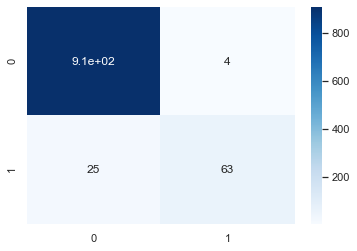

In [99]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [100]:
clf = XGBClassifier()
clf.fit(X_train, y_train, eval_metric=["auc"])
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("XGBoost's prediction accuracy using df.engineered is {} and AUC score is {}.".
      format(acc, auc))

XGBoost's prediction accuracy using df.engineered is 0.983 and AUC score is 0.9952153110047847.


<AxesSubplot:>

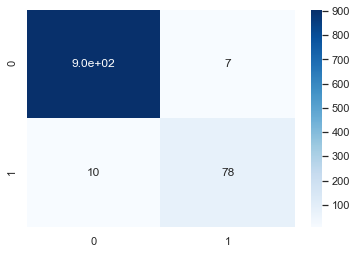

In [101]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [102]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("RandomForest's prediction accuracy using df.engineered is {} and AUC score is {}.".
      format(acc, auc))

RandomForest's prediction accuracy using df.engineered is 0.985 and AUC score is 0.9880382775119618.


<AxesSubplot:>

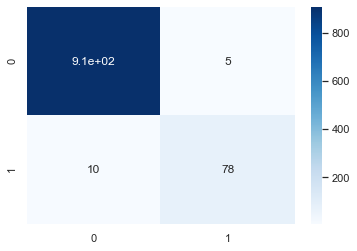

In [103]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [104]:
clf = ExtraTreesClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("ExtraTrees's prediction accuracy using df.engineered is {} and AUC score is {}.".
      format(acc, auc))

ExtraTrees's prediction accuracy using df.engineered is 0.975 and AUC score is 0.979453249601276.


<AxesSubplot:>

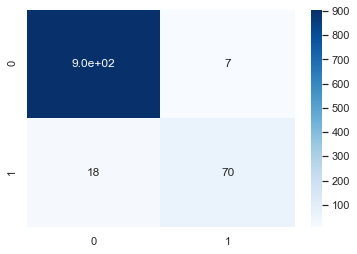

In [105]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [106]:
clf = BaggingClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Bagging's prediction accuracy using df.engineered is {} and AUC score is {}.".
      format(acc, auc))

Bagging's prediction accuracy using df.engineered is 0.979 and AUC score is 0.9898699162679427.


<AxesSubplot:>

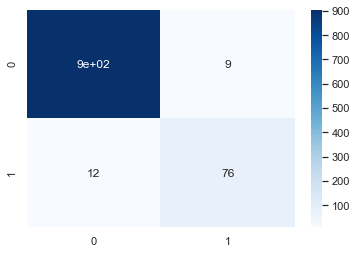

In [107]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [108]:
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("AdaBoost's prediction accuracy using df.enginereed is {} and AUC score is {}.".
      format(acc, auc))

AdaBoost's prediction accuracy using df.enginereed is 0.971 and AUC score is 0.9791168261562999.


<AxesSubplot:>

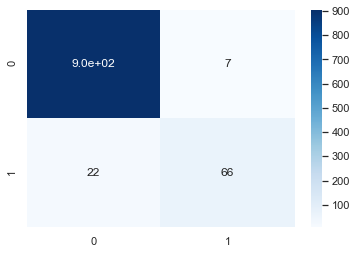

In [109]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [110]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("GradientBoosting's prediction accuracy using df.enginereed is {} and AUC score is {}.".
      format(acc, auc))

GradientBoosting's prediction accuracy using df.enginereed is 0.983 and AUC score is 0.9955205841307815.


<AxesSubplot:>

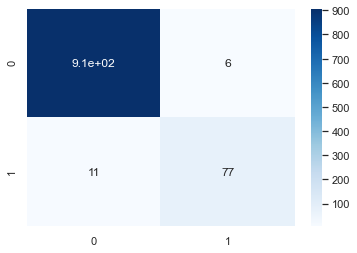

In [111]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [112]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("LogisticRegression's prediction accuracy using df.engineered is {} and AUC score is {}.".
      format(acc, auc))

LogisticRegression's prediction accuracy using df.engineered is 0.962 and AUC score is 0.9610870215311004.


<AxesSubplot:>

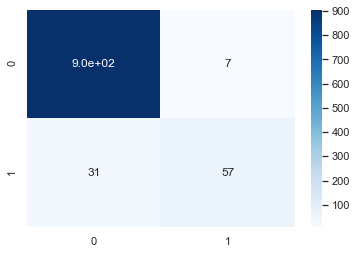

In [113]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [114]:
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier(eval_metric=["auc"])
rf_clf = RandomForestClassifier()
et_clf = ExtraTreesClassifier()
bag_clf = BaggingClassifier()
ada_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
lr_clf = LogisticRegression()
scores_knn = cross_val_score(knn_clf, X, y, cv = 5)
scores_xgb = cross_val_score(xgb_clf, X, y, cv = 5)
scores_rf = cross_val_score(rf_clf, X, y, cv = 5)
scores_et = cross_val_score(et_clf, X, y, cv = 5)
scores_bag = cross_val_score(bag_clf, X, y, cv = 5)
scores_ada = cross_val_score(ada_clf, X, y, cv = 5)
scores_gb = cross_val_score(gb_clf, X, y, cv = 5)
scores_lr = cross_val_score(lr_clf, X, y, cv = 5)
results = f"""
KNeighbors' prediction accuracy is {scores_knn.mean()}
XGBoost's prediction accuracy using df.engineered is {scores_xgb.mean()}
RandomForest's prediction accuracy using df.engineered is {scores_rf.mean()}
ExtraTrees's prediction accuracy using df.engineered is {scores_et.mean()}
Bagging's prediction accuracy using df.engineered is {scores_bag.mean()}
AdaBoost's prediction accuracy using df.engineered is {scores_ada.mean()}
GradientBoosting's prediction accuracy using df.engineered is {scores_gb.mean()}
LogisticRegression's prediction accuracy using df.engineered is {scores_lr.mean()}
"""
print(results)





KNeighbors' prediction accuracy is 0.9709999999999999
XGBoost's prediction accuracy using df.engineered is 0.9809999999999999
RandomForest's prediction accuracy using df.engineered is 0.9822
ExtraTrees's prediction accuracy using df.engineered is 0.9732
Bagging's prediction accuracy using df.engineered is 0.9812
AdaBoost's prediction accuracy using df.engineered is 0.9702
GradientBoosting's prediction accuracy using df.engineered is 0.9846
LogisticRegression's prediction accuracy using df.engineered is 0.9572



## Fine-tuning

After improving the dataset by reengineering it and then rerunning the classifiers, Random Forest is not the highest performing model anymore, it even slighly decreased from 98.47%  to 98.22%. Indeed now the most performant is Gradient Boosting with a slight amelioration from 98.43% to 98.46%. 

Additionaly, Logistic Regression is now the weakest model, which is due to KNeighbors' impressive amelioration from  85.84% to 97%. Indeed, KNN perfoms poorly when there are irrelevant features and poor quality data: it cannot handle noisy data, so the steps taken greatly helped. 

Nevertheless, they potentially still have room for improvement, which we are going to intend doing via a further extensive fine tuning. This time, we'll intent tweaking the number of estimators of GradientBoosting and RandomForest to find the most appropriate one. 

In [115]:
gb = GradientBoostingClassifier()
n_estimators = [100, 10, 50, 200, 500, 1000]
criterion = ["mse", "squared_error"]
parameters = {'n_estimators': n_estimators, 
              'criterion':  criterion}
clf = GridSearchCV(gb, parameters)
clf.fit(X, y)
sorted(clf.cv_results_.keys())




['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [116]:
clf.cv_results_['mean_test_score']

array([0.9846, 0.9678, 0.9848, 0.9832, 0.9816, 0.982 ,    nan,    nan,
          nan,    nan,    nan,    nan])

In [117]:
clf.cv_results_['params']

[{'criterion': 'mse', 'n_estimators': 100},
 {'criterion': 'mse', 'n_estimators': 10},
 {'criterion': 'mse', 'n_estimators': 50},
 {'criterion': 'mse', 'n_estimators': 200},
 {'criterion': 'mse', 'n_estimators': 500},
 {'criterion': 'mse', 'n_estimators': 1000},
 {'criterion': 'squared_error', 'n_estimators': 100},
 {'criterion': 'squared_error', 'n_estimators': 10},
 {'criterion': 'squared_error', 'n_estimators': 50},
 {'criterion': 'squared_error', 'n_estimators': 200},
 {'criterion': 'squared_error', 'n_estimators': 500},
 {'criterion': 'squared_error', 'n_estimators': 1000}]

In [118]:
clf = GradientBoostingClassifier(n_estimators=200)
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("GradientBoosting's prediction accuracy is {} and AUC score is {}.".
      format(acc, auc))

GradientBoosting's prediction accuracy is 0.983 and AUC score is 0.9954395933014355.


In [119]:
rf = RandomForestClassifier()
n_estimators = [100, 10, 50, 200, 500, 1000]
criterion = ["gini", "entropy"]
parameters = {'n_estimators': n_estimators, 
              'criterion':  criterion}
clf = GridSearchCV(rf, parameters)
clf.fit(X, y)
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [120]:
clf.cv_results_['mean_test_score']

array([0.9818, 0.9794, 0.9816, 0.9818, 0.982 , 0.9824, 0.9806, 0.977 ,
       0.9816, 0.9812, 0.9818, 0.9818])

In [121]:
clf.cv_results_['params']

[{'criterion': 'gini', 'n_estimators': 100},
 {'criterion': 'gini', 'n_estimators': 10},
 {'criterion': 'gini', 'n_estimators': 50},
 {'criterion': 'gini', 'n_estimators': 200},
 {'criterion': 'gini', 'n_estimators': 500},
 {'criterion': 'gini', 'n_estimators': 1000},
 {'criterion': 'entropy', 'n_estimators': 100},
 {'criterion': 'entropy', 'n_estimators': 10},
 {'criterion': 'entropy', 'n_estimators': 50},
 {'criterion': 'entropy', 'n_estimators': 200},
 {'criterion': 'entropy', 'n_estimators': 500},
 {'criterion': 'entropy', 'n_estimators': 1000}]

In [122]:
clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("RandomForest's prediction accuracy is {} and AUC score is {}.".
      format(acc, auc))

RandomForest's prediction accuracy is 0.984 and AUC score is 0.9880195873205742.


After fine tuning the best performing classifier –Random Forest– even further, we managed to increase the final accuracy score to 98.4% and AUC score to 98.76%, which is not a lot.


### Findings from modelling

To conclude, the model that seems to perform the best in this classifier task is Random Forest. In the final seciton, it resulted in an accuracy score of 98.9%, which is the highest of all. Moreover,it displays the most true positive and the least false negatives. Moreover, Gradient Boosting was also a high performer, but only after fine tuning the model.
On another hand, the worst ones were KNeighbors and Logistic Regression, even after preprocessing the dataset.
However, the results are still performant for every model. Some classifiers would have performed more poorly so it was ineffective to even include them. One example could be Naive Bayes: given the high correlation of some of the variables — Income with CCAvg or even Experience with Age — it would have performed poorly, since one of its requirement is to that variables are independent. 

## Conclusion


The aim of this predictive task was to examine whether it is possible to transform depositors into borrowers, or in other terms, to predict whether a customer is likely to make a Personal Loan at Thera Bank. 
To answer that, we applied a plethora of classification algorithms to our dataset. The result from this analysis would reflect how confident we could be in trusting the different best models, in this case trusting Random Forest and Gradient Boosting to tell us which class of customers is the most likekly to take personal loans. 